# Environmental Factors Influencing Drought in Aspen, Colorado

## Background

Drought is an environmental phenomenon when there is not enough water available is to meet demand (Bolinger et al., 2024). This project evaluates the impact of environmental factors on drought conditions in Aspen, Colorado, using data from mid-2010 to December 2023. Supervised (neural networks) and unsupervised (K-means clustering, PCA) machine learning techniques were used to assess feature importance and predict drought severity. Given the economic and environmental risks of drought, understanding key drivers and improving predictive models could aid mitigation efforts (Colorado Climate Action, n.d., & United States Department of Agriculture, 2017).

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.metrics import Recall
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, recall_score, silhouette_score
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

## Models

The df_class_aspen data frame was first split by the response variable, drought_level_encoded and the predictors, and the date column was removed. For supervised models the dataset was split into training and test sets (80/20 split), with stratified sampling. To ensure consistency, predictor variables were standardized using StandardScaler. From the correlation matrix there are many correlated features. The soil temperature and moister features are all highly correlated, however none of these features were removed, because differences in soil moisture and temperature at different levels have been shown to be important to droughts at different stages (Xu et al., 2021). Although daily high and low temperatures are also correlated, both were evaluated because they provide important information about the diurnal temperature range.

### Neural Network - Supervised Model 
A neural network was built with nine layers, including four dense layers with ReLU activation. Each dense layer was followed by a dropout layer to mitigate overfitting. The output layer contained five neurons, one for each classification category, with a softmax activation function for multi-class classification. Accuracy and recall scores were recorded to evaluate performance. 

In [5]:
# import the class_aspen.parquet dataset
df_class_aspen = pd.read_parquet('data/class_aspen.parquet')
# Separate predictor variables (X_all) and target variable (y_all)
X_all = df_class_aspen.drop(columns=['drought_level_encoded', 'date'])  
y_all = df_class_aspen['drought_level_encoded']

# Encode the target for classification
y_all_onehot = keras.utils.to_categorical(y_all, num_classes=5)

# Train-test split data
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y_all_onehot, test_size=0.2, random_state=42, stratify=y_all)

# Scale the data to keep the different attributes in same range
scaler = StandardScaler()
X_all_train_scaled = scaler.fit_transform(X_all_train)
X_all_test_scaled = scaler.transform(X_all_test)

In [7]:
# Define input shape
input_dim = X_all_train_scaled.shape[1]

# Build the NN model
nn_model  = Sequential([
    Input(shape=(input_dim,)),
    Dense(16, activation='relu'),
    Dropout(0.05),
    Dense(128, activation='relu'),
    Dropout(0.05),
    Dense(256, activation='relu'),
    Dropout(0.05),
    Dense(128, activation='relu'),
    Dropout(0.15),
    Dense(5, activation='softmax')  # use softmax activation for 5 class classification
])

print("\n---------------------- nn_model Summary -------------------------")
nn_model.summary()


---------------------- nn_model Summary -------------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,933 (269.27 KB)

 Trainable params: 68,933 (269.27 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Compile the model
nn_model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', Recall()])

In [11]:
# Train the model
history_all = nn_model.fit(X_all_train_scaled, y_all_train, 
                    validation_data=(X_all_test_scaled, y_all_test), 
                    epochs=150, 
                    batch_size=32, 
                    verbose=1); # suppress output for each epoch, set to 1 to print output

Epoch 1/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5303 - loss: 1.1833 - recall: 0.2679 - val_accuracy: 0.6548 - val_loss: 0.8947 - val_recall: 0.4560
Epoch 2/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6535 - loss: 0.8770 - recall: 0.5282 - val_accuracy: 0.6679 - val_loss: 0.7914 - val_recall: 0.5881
Epoch 3/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6884 - loss: 0.7483 - recall: 0.6076 - val_accuracy: 0.7155 - val_loss: 0.7050 - val_recall: 0.6548
Epoch 4/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7339 - loss: 0.6803 - recall: 0.6695 - val_accuracy: 0.7667 - val_loss: 0.6018 - val_recall: 0.7107
Epoch 5/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7379 - loss: 0.6339 - recall: 0.6788 - val_accuracy: 0.7345 - val_loss: 0.6290 - val_recall: 0.6821
Epoch 6/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7484 - loss: 0.6102 - recall: 0.6999 - val_accuracy: 0.7821 - val_loss: 0.5568 - val_recall: 0.759

In [13]:
# Last epoch accuracy and recall
test_results_all = nn_model.evaluate(X_all_test_scaled, y_all_test)
test_loss_all, test_acc_all, test_recall_all = test_results_all  
print(f"Test Accuracy on the Full Dataset: {test_acc_all:.2f}")
print(f"Test Recall on the Full Dataset: {test_recall_all:.2f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.9659 - loss: 0.0975 - recall: 0.9653
Test Accuracy on the Full Dataset: 0.97
Test Recall on the Full Dataset: 0.97


### K-means Clustering - Unsupervised
Inertial and silhouette scores were recoded to determine clustering efficiency. Also, the number of clusters hyperparameter (n_clusters), was optimized using 2, 3, 4, 5, 6 and 10 clusters.

In [15]:
# Scale the data to keep the different attributes in same range
X_all_scaled = scaler.fit_transform(X_all)

# number of clusters to test
clusters = [2, 3, 4, 5, 6, 10]
silhouette_scores_all = []
inertia_scores_all = []

for c in clusters:
    # Fit KMeans model
    kmeans_model = KMeans(n_clusters=c, random_state=42)
    kmeans_model.fit(X_all_scaled)  # Fit the model
    
    # Get silhouette score
    s_score = metrics.silhouette_score(X_all_scaled, kmeans_model.labels_)  
    i_score = kmeans_model.inertia_
    
    # Store the score
    silhouette_scores_all.append(s_score)
    inertia_scores_all.append(i_score)
    
    print(f'Number of Clusters = {c}, Inertia Score = {i_score}, Silhouette Score = {s_score:.4f}')

Number of Clusters = 2, Inertia Score = 28661.490969937655, Silhouette Score = 0.3686
Number of Clusters = 3, Inertia Score = 20709.22123489182, Silhouette Score = 0.4091
Number of Clusters = 4, Inertia Score = 17538.917585160765, Silhouette Score = 0.4252
Number of Clusters = 5, Inertia Score = 15860.45200758646, Silhouette Score = 0.3332
Number of Clusters = 6, Inertia Score = 14899.586597424752, Silhouette Score = 0.2651
Number of Clusters = 10, Inertia Score = 10758.826751441553, Silhouette Score = 0.2313


### Principal Component Analysis (PCA) - Unsupervised
PCA is a linear dimensionality reduction technique that transforms data into a lower-dimensional space while preserving maximum variance. Here, the number of components (n_components) was optimized to assess the most significant features (Pramoditha, 2025).

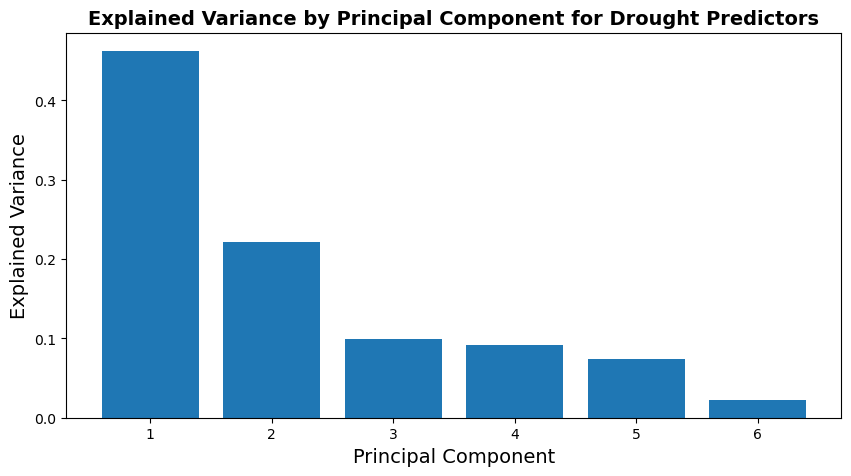

In [21]:
# Select predictors remove drought class
pca_list = ['prcp', 'tmax', 'tmin', 'gwl', 'sm_20cm', 'sm_50cm', 'sm_100cm', 'st_20cm', 'st_50cm', 'st_100cm', 'daily_discharge_cms']
X_pca = df_class_aspen[pca_list]

# Scale the predictors 
X_pca_scaled = StandardScaler().fit_transform(X_pca)

# Perform PCA
pca_6 = PCA(n_components=6)
pca_6_results = pca_6.fit_transform(X_pca_scaled)

# Create DataFrame for principal components
principalDf = pd.DataFrame(data=pca_6_results,
                           columns=['PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6'])

# Plotting the explained variance as a bar plot
plt.figure(figsize=(10,5))
plt.bar(range(1, 7), pca_6.explained_variance_ratio_)
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Explained Variance by Principal Component for Drought Predictors', fontsize=14, fontweight = 'bold')
# Save plot locally (optional)
#plt.savefig('data/PCA_Explained_Variance_Bar.jpg')
plt.show()

In [23]:
# Create a DataFrame for the PCA components and their coefficients with variable labels

pca_dataset = pd.DataFrame(abs(pca_6.components_), columns=pca_list, index=[f'PC_{i+1}' for i in range(6)])
pca_dataset = pca_dataset.round(3)

#To save as an excel table (optional)
#pca_dataset.to_excel('data/pca_coefficients.xlsx')

# Print the PCA dataset
print('\n\n', pca_dataset)



        prcp   tmax   tmin    gwl  sm_20cm  sm_50cm  sm_100cm  st_20cm  \
PC_1  0.005  0.394  0.387  0.055    0.315    0.071     0.094    0.430   
PC_2  0.045  0.199  0.226  0.086    0.366    0.613     0.602    0.101   
PC_3  0.241  0.038  0.092  0.794    0.077    0.120     0.030    0.063   
PC_4  0.957  0.160  0.027  0.193    0.034    0.046     0.010    0.008   
PC_5  0.007  0.047  0.057  0.538    0.080    0.025     0.107    0.031   
PC_6  0.027  0.287  0.408  0.096    0.696    0.263     0.406    0.083   

      st_50cm  st_100cm  daily_discharge_cms  
PC_1    0.435     0.428                0.148  
PC_2    0.035     0.072                0.110  
PC_3    0.075     0.089                0.513  
PC_4    0.005     0.010                0.130  
PC_5    0.027     0.025                0.827  
PC_6    0.095     0.081                0.013  


### Neural Network - Supervised Model - PCA Reduced Dataset

The features prcp and gwl were removed based on PCA results, and the remaining data was processed as previously described. A neural network was then trained on the PCA-reduced training set, with accuracy and recall scores recorded. To improve performance, slight modifications were made to the architecture. The number of neurons in the first dense layer was increased from 16 to 64, while the other dense layers remained unchanged. Dropout levels were slightly increased to mitigate overfitting, which was more pronounced with the reduced dataset. Additionally, the number of training epochs needed to be increased to ensure model convergence.

In [25]:
# Separate predictor variables (X) and target variable (y)
X_pca = df_class_aspen.drop(columns=['prcp', 'gwl', 'drought_level_encoded', 'date'])  
y_pca = df_class_aspen['drought_level_encoded']

# Encode the target for classification
y_pca_onehot = keras.utils.to_categorical(y_pca, num_classes=5)

# Train-test split data
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y_pca_onehot, test_size=0.2, random_state=42, stratify=y_pca)

# Scale the data to keep the different attributes in same range
scaler = StandardScaler()
X_pca_train_scaled = scaler.fit_transform(X_pca_train)
X_pca_test_scaled = scaler.transform(X_pca_test)

In [27]:
# Define input shape
input_dim = X_pca_train_scaled.shape[1]

# Build the NN model
nn_pca_model = Sequential([
    Input(shape=(input_dim,)),  
    Dense(64, activation='relu'),
    Dropout(0.10),
    Dense(128, activation='relu'),
    Dropout(0.10),
    Dense(256, activation='relu'),
    Dropout(0.10),
    Dense(128, activation='relu'),
    Dropout(0.30),
    Dense(5, activation='softmax')
])

print("\n-------------------- nn_pca_model Summary -----------------------")
nn_pca_model.summary()


-------------------- nn_pca_model Summary -----------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,525 (295.02 KB)

 Trainable params: 75,525 (295.02 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Compile the model
nn_pca_model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', Recall()])

In [31]:
# Train the model
history_pca = nn_pca_model.fit(X_pca_train_scaled, y_pca_train, 
                    validation_data=(X_pca_test_scaled, y_pca_test), 
                    epochs=200, 
                    batch_size=32, 
                    verbose=1); 

Epoch 1/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4882 - loss: 1.2361 - recall_1: 0.2312 - val_accuracy: 0.5726 - val_loss: 0.9809 - val_recall_1: 0.3512
Epoch 2/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5983 - loss: 0.9894 - recall_1: 0.4324 - val_accuracy: 0.6167 - val_loss: 0.8725 - val_recall_1: 0.5524
Epoch 3/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6340 - loss: 0.8786 - recall_1: 0.5206 - val_accuracy: 0.6440 - val_loss: 0.8058 - val_recall_1: 0.5929
Epoch 4/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6553 - loss: 0.8286 - recall_1: 0.5617 - val_accuracy: 0.6524 - val_loss: 0.7690 - val_recall_1: 0.5798
Epoch 5/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6459 - loss: 0.8015 - recall_1: 0.5666 - val_accuracy: 0.6643 - val_loss: 0.7380 - val_recall_1: 0.5976
Epoch 6/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6774 - loss: 0.7699 - recall_1: 0.5880 - val_accuracy: 0.6964 - val_loss: 0.69

In [33]:
# Last epoch accuracy and recall - PCA reduced dataset
test_results_pca = nn_pca_model.evaluate(X_pca_test_scaled, y_pca_test)
test_loss_pca, test_acc_pca, test_recall_pca = test_results_pca  
print(f"Test Accuracy on the PCA Reduced Dataset: {test_acc_pca:.2f}")
print(f"Test Recall on the PCA Reduced Dataset: {test_recall_pca:.2f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.9353 - loss: 0.1840 - recall_1: 0.9335
Test Accuracy on the PCA Reduced Dataset: 0.93
Test Recall on the PCA Reduced Dataset: 0.93


### K-means Clustering - Unsupervised - PCA Reduced Dataset

K-means clustering was also performed on the PCA reduced dataset. No changes were made to the K-means algorithm for use with the reduced data. Inertial and silhouette scores were recorded, and the model’s performance was again assessed on 2, 3, 4, 5, 6 and 10 clusters. 

In [35]:
# Scale the data to keep the different attributes in same range
X_pca_scaled = scaler.fit_transform(X_pca)

clusters = [2, 3, 4, 5, 6, 10]
silhouette_scores_pca = []
inertia_scores_pca = []

for c in clusters:
    # Fit KMeans model
    kmeans_model = KMeans(n_clusters=c, random_state=42)
    kmeans_model.fit(X_pca_scaled)  # Fit the model
    
    # Get silhouette score
    s_score = metrics.silhouette_score(X_pca_scaled, kmeans_model.labels_)  
    i_score = kmeans_model.inertia_
    
    # Store the score
    silhouette_scores_pca.append(s_score)
    inertia_scores_pca.append(i_score)
    
    print(f'Number of Clusters = {c}, Inertia Score = {i_score}, Silhouette Score = {s_score:.4f}')

Number of Clusters = 2, Inertia Score = 20297.49250358544, Silhouette Score = 0.4409
Number of Clusters = 3, Inertia Score = 12383.253112048793, Silhouette Score = 0.5074
Number of Clusters = 4, Inertia Score = 10652.14556991875, Silhouette Score = 0.4194
Number of Clusters = 5, Inertia Score = 7661.976948340756, Silhouette Score = 0.4508
Number of Clusters = 6, Inertia Score = 6498.583385475852, Silhouette Score = 0.4309
Number of Clusters = 10, Inertia Score = 4636.099043294734, Silhouette Score = 0.2988


## Results

Classification and clustering results were compared for neural networks and k-means clustering algorithms trained on both the full dataset and the PCA-reduced dataset. PCA guided feature selection helped with unsupervised clustering but did not enhance supervised neural network perfromance. PCAs impact on clustering was further examined using data visualization.

### PCA
PCA was used for feature selection, leveraging the first two principal components, which together capture approximately 68% of the variance in the dataset. After applying PCA, the absolute values of the variable coefficients were examined to determine feature importance (Singh, 2022). Here, variables with absolute coefficients greater than 0.1 in the first two principal components were selected. Based on this criterion, the most significant features were included, maximum and minimum temperature, soil moisture at 20 cm, 50 cm, and 100 cm depths, soil temperature at 20 cm, 50 cm, and 100 cm depths, and daily river discharge.

In [37]:
print('The explained variance of principal component 1 is', round(pca_6.explained_variance_ratio_[0], 2))
print('The explained variance of principal component 2 is', round(pca_6.explained_variance_ratio_[1], 2))

The explained variance of principal component 1 is 0.46
The explained variance of principal component 2 is 0.22


In [39]:
# PCA results table

""" 
#To save as an excel table
pca_results = pd.DataFrame({
    'PC1 Loading': pca_dataset[pca_dataset > 0.1].iloc[0].dropna(),
    'PC2 Loading': pca_dataset[pca_dataset > 0.1].iloc[1].dropna()
})

pca_results = pca_results.round(3)

pca_results.to_excel('/Users/michaelgrybko/Desktop/MSDS/ClimateChange/PredictingExtremeClimateBehavior/FinalProject/pca_feature_importance.xlsx')
"""

print("\n------------- Most important features based on PCA ---------------")
print('As per Principal Component 1:\n', (pca_dataset[pca_dataset > 0.1].iloc[0]).dropna())   
print('\n\nAs per Principal Component 2:\n', (pca_dataset[pca_dataset > 0.1].iloc[1]).dropna())
print("\n------------------------------------------------------------------")


------------- Most important features based on PCA ---------------
As per Principal Component 1:
 tmax                   0.394
tmin                   0.387
sm_20cm                0.315
st_20cm                0.430
st_50cm                0.435
st_100cm               0.428
daily_discharge_cms    0.148
Name: PC_1, dtype: float64


As per Principal Component 2:
 tmax                   0.199
tmin                   0.226
sm_20cm                0.366
sm_50cm                0.613
sm_100cm               0.602
st_20cm                0.101
daily_discharge_cms    0.110
Name: PC_2, dtype: float64

------------------------------------------------------------------


### Neural Networks
The neural network trained on the full dataset outperformed the model trained on the PCA-reduced dataset. The test accuracy for the full dataset model reached approximately 97%, compared to 92% for the PCA-reduced model. Since failing to predict a drought, could have severe environmental and economic consequences, recall was closely examined. 

#### Training and Testing Accuracy

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.9659 - loss: 0.0975 - recall: 0.9653
Test Accuracy on the Full Dataset: 0.97
Test Recall on the Full Dataset: 0.97
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.9353 - loss: 0.1840 - recall_1: 0.9335
Test Accuracy on the PCA Reduced Dataset: 0.93
Test Recall on the PCA Reduced Dataset: 0.93


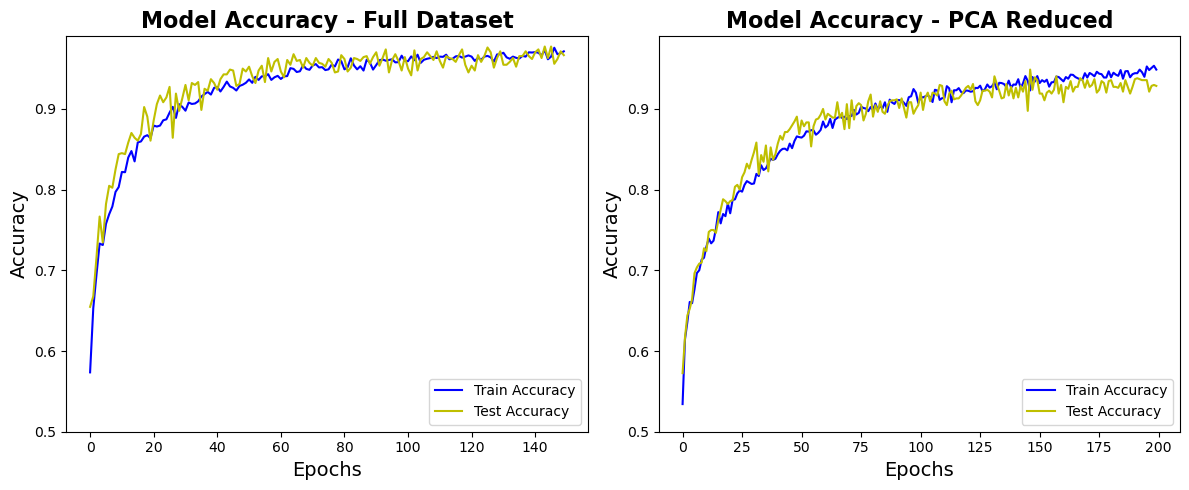

In [41]:
# Evaluate on test data - complete dataset
test_results_all = nn_model.evaluate(X_all_test_scaled, y_all_test)
test_loss_all, test_acc_all, test_recall_all = test_results_all  
print(f"Test Accuracy on the Full Dataset: {test_acc_all:.2f}")
print(f"Test Recall on the Full Dataset: {test_recall_all:.2f}")

# Evaluate on test data - PCA reduced dataset
test_results_pca = nn_pca_model.evaluate(X_pca_test_scaled, y_pca_test)
test_loss_pca, test_acc_pca, test_recall_pca = test_results_pca  
print(f"Test Accuracy on the PCA Reduced Dataset: {test_acc_pca:.2f}")
print(f"Test Recall on the PCA Reduced Dataset: {test_recall_pca:.2f}")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Complete dataset accuracy
axes[0].plot(history_all.history['accuracy'], label='Train Accuracy', color='b')
axes[0].plot(history_all.history['val_accuracy'], label='Test Accuracy', color='y')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy', fontsize = 14)
axes[0].set_ylim(0.50, 0.99)
axes[0].set_title('Model Accuracy - Full Dataset', fontsize = 16, fontweight = 'bold')
axes[0].legend(loc = 'lower right')


# PCA-reduced dataset accuracy
axes[1].plot(history_pca.history['accuracy'], label='Train Accuracy', color='b')
axes[1].plot(history_pca.history['val_accuracy'], label='Test Accuracy', color='y')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Accuracy', fontsize = 14)
axes[1].set_ylim(0.50, 0.99)
axes[1].set_title('Model Accuracy - PCA Reduced', fontsize = 16, fontweight = 'bold')
axes[1].legend(loc = 'lower right')

plt.tight_layout() 
# Save plot (optional)
#plt.savefig('data/NN_Accuracy_per_Epoch.jpg')
plt.show()

#### Predictions, Classification Reports, and Confusion Matrices

In [44]:
# Get predicted probabilities - full dataset
y_all_pred_probs = nn_model.predict(X_all_test_scaled)

# Convert probabilities to classes
y_all_pred_classes = np.argmax(y_all_pred_probs, axis=1)

# Convert one-hot encoded y_test back to class labels
y_all_true_classes = np.argmax(y_all_test, axis=1)

# Compute recall score
recall_all = recall_score(y_all_true_classes, y_all_pred_classes, average='weighted')

# Compute confusion matrix - full dataset
conf_matrix_all = confusion_matrix(y_all_true_classes, y_all_pred_classes)

# Get predicted probabilities - PCA reduced dataset
y_pca_pred_probs = nn_pca_model.predict(X_pca_test_scaled)

# Convert probabilities to classes
y_pca_pred_classes = np.argmax(y_pca_pred_probs, axis=1)

# Convert encoded y_test back to class labels
y_pca_true_classes = np.argmax(y_pca_test, axis=1)

# Compute recall score
recall_pca = recall_score(y_pca_true_classes, y_pca_pred_classes, average='weighted')

# Compute confusion matrix - PCA reduced dataset
conf_matrix_nn_pca = confusion_matrix(y_pca_true_classes, y_pca_pred_classes)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [60]:
# Classification Report Full dataset

# PCA results table
nn_full_classification_report = classification_report(y_all_true_classes, y_all_pred_classes, output_dict=True)
nn_full_classification_report = pd.DataFrame(nn_full_classification_report).transpose()
nn_full_classification_report = nn_full_classification_report.round(3)
#To save as an excel table (optional)
#nn_full_classification_report.to_excel('data/nn_full_classification_report.xlsx')


print('\n-- Classification Report for Neural Network with Full Dataset --')
print(nn_full_classification_report)
print(f'Weighted Recall for the Full Dataset: {recall_all:.4f}')
print('\n----------------------------------------------------------------')


-- Classification Report for Neural Network with Full Dataset --
              precision  recall  f1-score  support
0                 0.980   0.976     0.978  449.000
1                 0.953   0.984     0.968  246.000
2                 0.971   0.905     0.937   74.000
3                 0.977   0.935     0.956   46.000
4                 0.846   0.880     0.863   25.000
accuracy          0.967   0.967     0.967    0.967
macro avg         0.945   0.936     0.940  840.000
weighted avg      0.967   0.967     0.967  840.000
Weighted Recall for the Full Dataset: 0.9667

----------------------------------------------------------------


In [62]:
# Classification Report PCA Reduced
 

# PCA results table
nn_reduced_classification_report = classification_report(y_pca_true_classes, y_pca_pred_classes, output_dict=True)
nn_reduced_classification_report = pd.DataFrame(nn_reduced_classification_report).transpose()
nn_reduced_classification_report = nn_reduced_classification_report.round(3)
# To save as an excel table (optional)
#nn_reduced_classification_report.to_excel('data/nn_reduced_classification_report.xlsx')


print('\n-- Classification Report for Neural Network PCA Reduced Dataset --')
print(nn_reduced_classification_report)
print(f'Weighted Recall for the PCA Reduced Dataset: {recall_pca:.4f}')
print('\n------------------------------------------------------------------')


-- Classification Report for Neural Network PCA Reduced Dataset --
              precision  recall  f1-score  support
0                 0.944   0.944     0.944  449.000
1                 0.908   0.886     0.897  246.000
2                 0.946   0.946     0.946   74.000
3                 0.900   0.978     0.938   46.000
4                 0.852   0.920     0.885   25.000
accuracy          0.929   0.929     0.929    0.929
macro avg         0.910   0.935     0.922  840.000
weighted avg      0.929   0.929     0.928  840.000
Weighted Recall for the PCA Reduced Dataset: 0.9286

------------------------------------------------------------------


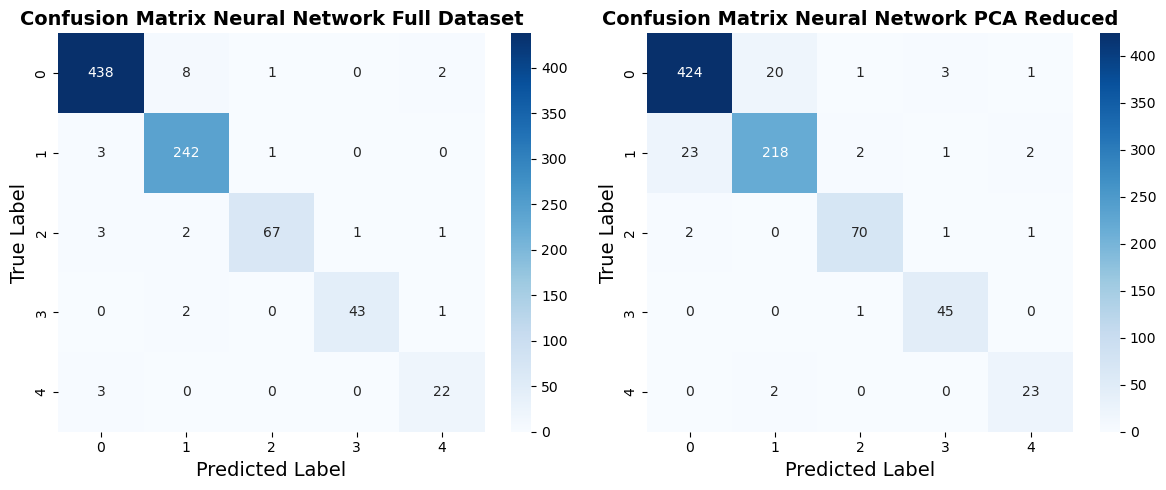

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Confusion matrix for full dataset
sns.heatmap(conf_matrix_all, ax = axes[0], annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
axes[0].set_xlabel('Predicted Label', fontsize =14)
axes[0].set_ylabel('True Label', fontsize =14)
axes[0].set_title('Confusion Matrix Neural Network Full Dataset', fontsize =14, fontweight = 'bold')

# Confusion matrix for PCA reduced dataset
sns.heatmap(conf_matrix_nn_pca, ax = axes[1], annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
axes[1].set_xlabel('Predicted Label', fontsize =14)
axes[1].set_ylabel('True Label', fontsize=14)
axes[1].set_title('Confusion Matrix Neural Network PCA Reduced', fontsize =14, fontweight = 'bold')

plt.tight_layout()
# To save confusion matrix (optional)
#plt.savefig('data/NN_Confusion_Matrix.jpg')
plt.show()

### K-means Clustering

For clustering evaluation, the inertia score was used to measure how tightly data points were clustered. Additionally, the silhouette score was used to assess cluster separation, ranging from -1 to 1, with higher scores indicating better-defined clusters (Singh, 2022).

Based on these metrics both datasets could be partitioned optimally into four or five clusters. Comparing the inertia and silhouette plots for both datasets, the PCA-reduced dataset exhibited lower inertia scores and higher silhouette scores than the full dataset. This suggests that PCA improved clustering performance by enhancing cluster separation and reducing within-cluster variance.

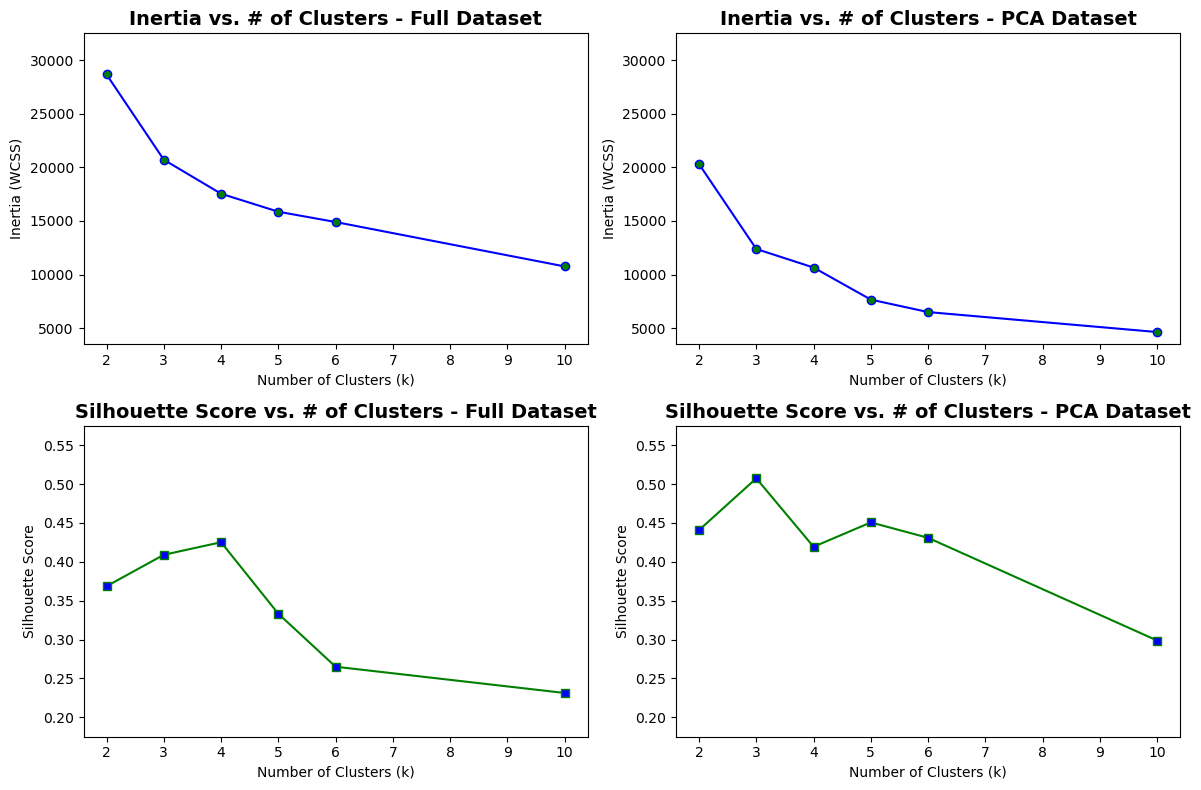

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

# Plot Inertia Elbow Method - full dataset 
axes[0,0].plot(clusters, inertia_scores_all, marker='o', linestyle='-', color='b', markerfacecolor='g')
axes[0,0].set_xlabel('Number of Clusters (k)')
axes[0,0].set_ylabel('Inertia (WCSS)')
axes[0,0].set_ylim(3500, 32500)
axes[0,0].set_title('Inertia vs. # of Clusters - Full Dataset', fontsize =14, fontweight = 'bold')

# Plot Silhouette Score - full dataset
axes[1,0].plot(clusters, silhouette_scores_all, marker='s', linestyle='-', color='g', markerfacecolor='b')
axes[1,0].set_xlabel('Number of Clusters (k)')
axes[1,0].set_ylabel('Silhouette Score')
axes[1,0].set_ylim(0.175, 0.575)
axes[1,0].set_title('Silhouette Score vs. # of Clusters - Full Dataset', fontsize =14, fontweight = 'bold')

# Plot Inertia Elbow Method - PCA dataset 
axes[0,1].plot(clusters, inertia_scores_pca, marker='o', linestyle='-', color='b', markerfacecolor='g')
axes[0,1].set_xlabel('Number of Clusters (k)')
axes[0,1].set_ylabel('Inertia (WCSS)')
axes[0,1].set_ylim(3500, 32500)
axes[0,1].set_title('Inertia vs. # of Clusters - PCA Dataset', fontsize =14, fontweight = 'bold')

# Plot Silhouette Score - PCA dataset
axes[1,1].plot(clusters, silhouette_scores_pca, marker='s', linestyle='-', color='g', markerfacecolor='b')
axes[1,1].set_xlabel('Number of Clusters (k)')
axes[1,1].set_ylabel('Silhouette Score')
axes[1,1].set_ylim(0.175, 0.575)
axes[1,1].set_title('Silhouette Score vs. # of Clusters - PCA Dataset', fontsize =14, fontweight = 'bold')

plt.tight_layout()
# to save plots (optional)
#plt.savefig('data/Kmeans_Results.jpg')
plt.show()

### Data Visualization with K-means Clustering and PCA

PCA can be a powerful tool for data visualization when using two or three principal components (Pramoditha, 2025; Singh, 2022). To further explore how PCA influenced the clustering efficiency of the K-means algorithm, both the full and PCA-reduced datasets were analyzed using K-means clustering with five clusters and two principal components.The clustered data points were visualized on a scatter plot, with individual points color-coded by cluster assignment. Examining the scatter plots, the PCA-reduced dataset exhibits more compact and well-separated clusters, indicating that PCA effectively reduced noise and improved clustering performance.

In [54]:
# Define number of clusters 
optimal_k = 5

# Fit KMeans on full dataset
kmeans_full = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_full = kmeans_full.fit_predict(X_all_scaled)

# Compute silhouette score
silhouette_full = silhouette_score(X_all, labels_full)
print(f"Silhouette Score Full Dataset, 5 Clusters: {silhouette_full:.4f}")

Silhouette Score Full Dataset, 5 Clusters: -0.1816


In [56]:
# Reduce dimensions with PCA
pca = PCA(n_components=2)  # Use 2 components for visualization
X_pca_2 = pca.fit_transform(X_all_scaled)

# Fit KMeans on PCA-reduced dataset
kmeans_pca = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_pca = kmeans_pca.fit_predict(X_pca_2)

# Compute silhouette score for PCA data
silhouette_pca = silhouette_score(X_pca_2, labels_pca)
print(f"Silhouette Score PCA Reduced Dataset, 5 Clusters : {silhouette_pca:.4f}")

Silhouette Score PCA Reduced Dataset, 5 Clusters : 0.5429


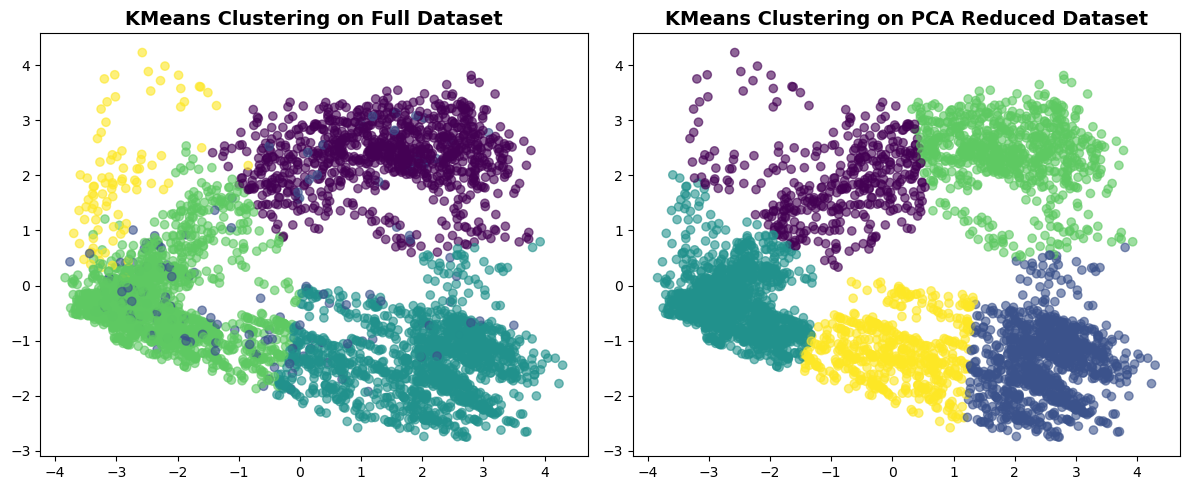

In [58]:
plt.figure(figsize=(12, 5))

# Plot KMeans clusters on full dataset using PCA for visualization
plt.subplot(1, 2, 1)
plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=labels_full, cmap='viridis', alpha=0.6)
plt.title("KMeans Clustering on Full Dataset", fontsize=14, fontweight='bold')

# Plot KMeans clusters on PCA-reduced dataset
plt.subplot(1, 2, 2)
plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=labels_pca, cmap='viridis', alpha=0.6)
plt.title("KMeans Clustering on PCA Reduced Dataset", fontsize=14, fontweight='bold')

plt.tight_layout()
# To save plots (optional)
#plt.savefig('data/Kmeans_Scatter.jpg')
plt.show()

## Conclusion

This study assembled a dataset with variables related to soil moisture and temperature, streamflow, groundwater level, precipitation, and air temperature to analyze drought conditions in Aspen, CO. A neural network achieved over 95% accuracy in classifying drought severity. Since minimizing false negatives, misclassifying drought conditions as non-drought is critical, recall was a primary focus. The model achieved a 97% total recall demonstrating strong predictive performance.

Applying PCA improved K-means clustering but did not enhance neural network performance. This result aligns with expectations. The full dataset contained correlated features known to be important for drought prediction (Xu et al., 2021). K-means clustering, which relies on Euclidean distance, struggles with highly correlated variables, leading to poorly defined clusters. PCA, by removing linear dependencies, allowed K-means to capture clearer patterns. However, neural networks, with their ability to model non-linear relationships, retained crucial predictive power even with correlated features. This suggests that while PCA can enhance clustering, reducing the dataset may remove valuable information for accurate drought prediction.


## References

### Text References

Bolinger, R.A., J.J. Lukas, R.S. Schumacher, and P.E. Goble, 2024: Climate Change in Colorado, 3rd edition. Colorado State University, https://doi.org/10.25675/10217/237323.

Colorado Climate Action. Climate Change in Colorado: Public Health and Environmental Impacts | Climate. climate.colorado.gov/health-and-environmental-impacts.

Pramoditha, Rukshan. “How to Select the Best Number of Principal Components for the Dataset.” Towards Data Science, 28 Jan. 2025, https://towardsdatascience.com/how-to-select-the-best-number-of-principal-components-for-the-dataset-287e64b14c6d/.

Singh, Shivangi. “K Means Clustering on High Dimensional Data. - the Startup - Medium.” Medium, 10 Apr. 2022, https://medium.com/swlh/k-means-clustering-on-high-dimensional-data-d2151e1a4240

United States Department of Agriculture. Drought Impacts in the Rocky Mountain Region. Sept. 2017, www.fs.usda.gov/sites/default/files/r2-droughtfactsheet.pdf.

Xu, Zheng-Guang, et al. “Comparison of Soil Moisture at Different Depths for Drought Monitoring Based on Improved Soil Moisture Anomaly Percentage Index.” Water Science and Engineering, vol. 14, no. 3, Aug. 2021, pp. 171–83. https://doi.org/10.1016/j.wse.2021.08.008.


### Data Sources

Weather data, precipitation, max temperature and min temperature, Aspen Pitkin Co Airport Sardy Field, CO US:
https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00093073/detail

Daily discharge data for Lincoln Creek, Near Aspen, CO:
https://dashboard.waterdata.usgs.gov/api/gwis/2.1/service/site?agencyCode=USGS&siteNumber=09073005&open=211313

Ground water level data, drought well near Aspen, CO:
https://dashboard.waterdata.usgs.gov/api/gwis/2.1/service/site?agencyCode=USGS&siteNumber=395136108210004&open=212313

Soil moisture and temperature data Montrose, CO: 
https://www.ncei.noaa.gov/data/us-climate-reference-network/access/derived-products/soil/soilanom/

Drought data, Pitkin County, CO:
https://www.drought.gov/states/colorado/county/pitkin
